In [47]:
import cv2
import numpy as np
import scipy.stats as stats
import skimage
import imageio
import mpmath
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from scipy.stats import multivariate_normal
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import threshold_mean
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import sklearn.metrics
from scipy.signal import convolve2d
import sklearn
from sklearn.cluster import KMeans

In [48]:
image_path = '../images/'

In [49]:
# Reading in images and mapping to RGB

image1 = img_as_float(cv2.imread(image_path + 'image-35.jpg')[:,:,::-1])
image2 = img_as_float(cv2.imread(image_path +  'image-83.jpg')[:,:,::-1])
image3 = img_as_float(cv2.imread(image_path +  'image-110.jpg')[:,:,::-1])



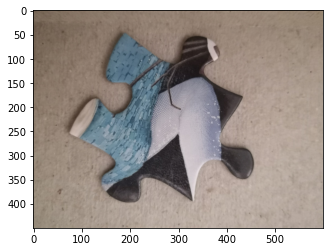

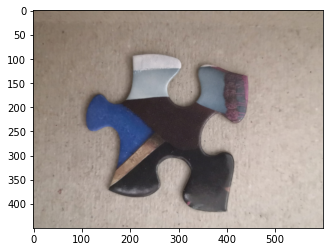

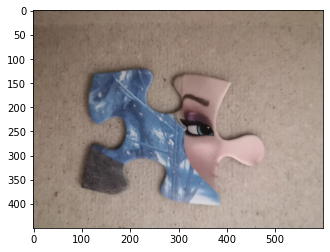

In [50]:
plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()


## 1 Additional Filters

[[0.00864226 0.00919964 0.00919964]
 [0.00919964 0.00979297 0.00979297]
 [0.00919964 0.00979297 0.00979297]]


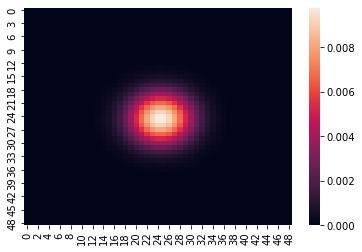

In [51]:
#1
def gauss(sigma, kernel_size,k = 1):
	x, y = np.meshgrid(np.arange(-kernel_size/2,kernel_size/2),np.arange(-kernel_size/2,kernel_size/2))
	d = x*x+y*y
	c = (1/ (2* np.pi*(k**2)*sigma**2))
	g = c * np.exp(-( d / ( 2.0 * (k**2) * sigma**2 ) ) )
 
	return g

print(gauss(4,3))
_ = sns.heatmap(gauss(4,49))

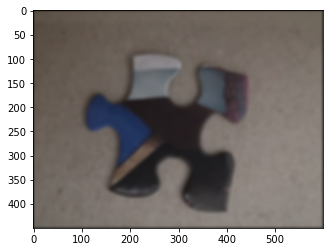

In [52]:
SIGMA = 4
SIZE = 11

#kernel_Size = ceil[6*SIGMA]

img_gauss = np.zeros(image2.shape, dtype=np.float64)

g = gauss(SIGMA,SIZE)

for c in range(3):
    img_gauss[:, :, c] = convolve2d(image2[:, :, c], g, mode = 'same')

plt.imshow(img_gauss)

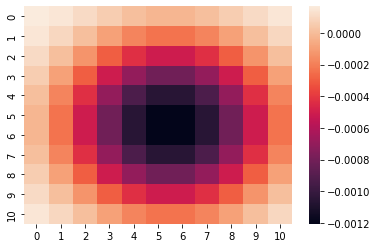

In [53]:
#2
def LoG(sigma, kernel_size):
	# x, y = np.meshgrid(np.arange(-kernel_size//2,kernel_size//2),np.arange(-kernel_size//2,kernel_size//2))
	# x, y = np.meshgrid(np.linspace(-1,1,kernel_size), np.linspace(-1,1,kernel_size))
	x, y = np.meshgrid(np.arange(-kernel_size/2,kernel_size/2),np.arange(-kernel_size/2,kernel_size/2))
 
	# d = x**2+y**2

	# c = -1 / (np.pi * (sigma**4))
	
	# k = 1 - (d / (2 * (sigma**2)))
 
	# l = c * k
	
	# e = - d / (2 * (sigma**2))
 
	# g = l * np.exp(e)

	d = x**2+y**2
	c = ( - (1/ (np.pi * (sigma**4))) * (1 - d/(2*(sigma**2))))

	g = c * np.exp(-( d / ( 2.0 * (sigma**2) ) ) )
	

	return g

# print(LoG(2,11))
_ = sns.heatmap(LoG(SIGMA,SIZE))

-0.03816757310945589 -0.004027280573868275


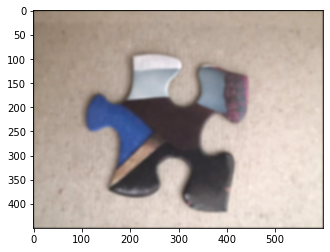

In [94]:
img_log = np.zeros(image2.shape, dtype=np.float64)

g = LoG(SIGMA,SIZE)

for c in range(3):
    img_log[:, :, c] = convolve2d(image2[:, :, c], g, mode = 'same')

plt.imshow(img_log/np.min(img_log))

[[-0.00924734  0.0050139   0.0050139 ]
 [ 0.0050139   0.06065306  0.06065306]
 [ 0.0050139   0.06065306  0.06065306]]


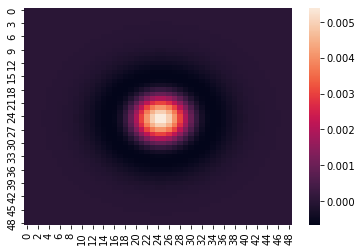

In [55]:
#3
def DoG(sigma,kernal_size,K):
    return gauss(sigma,kernal_size) - gauss(sigma,kernal_size,k=K)

print(DoG(1,3,1.5))
_ = sns.heatmap(DoG(SIGMA,49,1.5))

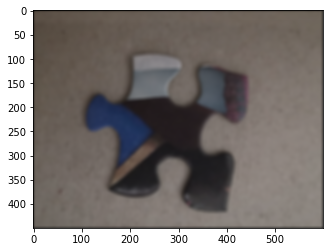

In [120]:
img_dog = np.zeros(image2.shape, dtype=np.float64)

g = DoG(SIGMA, SIZE, 10)

for c in range(3):
    img_dog[:, :, c] = convolve2d(image2[:, :, c], g, mode = 'same')

plt.imshow(img_dog)

## 2 Gaussian Edge and Bar Filters - The RFS/MR8 Filter Banks

In [57]:
#1
def xy_dash(x,y,theta):
    x_dash = x*np.cos(theta)-y*np.sin(theta)
    y_dash = x*np.sin(theta)+y*np.cos(theta)

    return x_dash,y_dash

def f(x,sigma):
    c =1/(np.sqrt(2*np.pi)*sigma)
    f = c* np.exp(-((x**2)/(2*(sigma**2))))
    return f

def df(x,sigma):
    return f(x,sigma)*(-(x/(sigma**2)))

def dfsquared(x,sigma):
    return f(x,sigma)*(((x**2)-(sigma**2))/(sigma**4))

def g_edge(x,y,theta,sigma_x,sigma_y):
    x_new, y_new = xy_dash(x,y,theta)
    a = f(x_new,sigma_x)
    b = df(y_new,sigma_y)
    return a*b

def g_bar(x,y,theta,sigma_x,sigma_y):
    x_new, y_new = xy_dash(x,y,theta)
    a = f(x_new,sigma_x)
    b = dfsquared(y_new,sigma_y)
    return a*b

def gaussian(theta, sigma_x, sigma_y, kernel_size, edge=True):
    # x, y = np.meshgrid(np.linspace(-1,1,kernel_size), np.linspace(-1,1,kernel_size))
    x, y = np.meshgrid(np.arange(-kernel_size/2,kernel_size/2),np.arange(-kernel_size/2,kernel_size/2))
    if edge:
        return g_edge(x, y, theta, sigma_x, sigma_y)
    else:
        return g_bar(x, y, theta, sigma_x, sigma_y)

In [75]:
gau_bar = gaussian(np.pi/2, 1, 0.1, SIZE, edge=False)
gau_edge =  gaussian(np.pi/2, 1, 0.1, SIZE, edge=True)

img_bar = np.zeros(image2.shape)
img_edge = np.zeros(image2.shape)

for c in range(3):
    img_bar[:, :, c] = convolve2d(image2[:, :, c], gau_bar, mode='same')
    img_edge[:, :, c] = convolve2d(image2[:, :, c], gau_edge, mode='same')

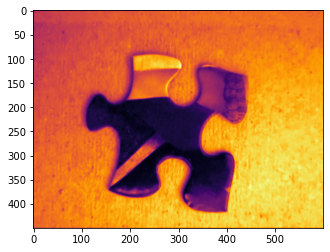

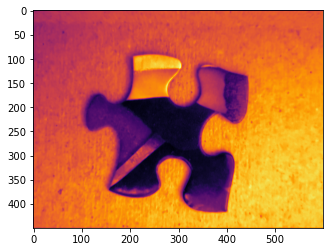

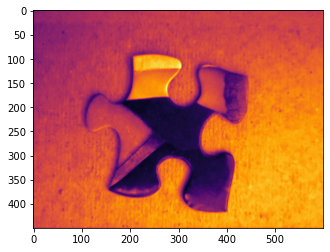

In [113]:
plt.imshow(img_bar[:,:,0],cmap="inferno")
plt.show()
plt.imshow(img_bar[:,:,1],cmap="inferno")
plt.show()
plt.imshow(img_bar[:,:,2],cmap="inferno")
plt.show()

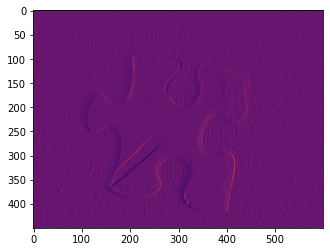

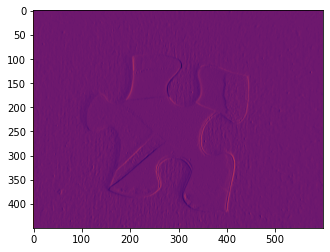

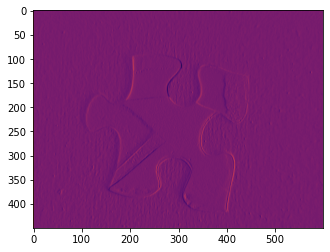

In [114]:
plt.imshow(img_edge[:,:,0],cmap="inferno")
plt.show()
plt.imshow(img_edge[:,:,1],cmap="inferno")
plt.show()
plt.imshow(img_edge[:,:,2],cmap="inferno")
plt.show()

In [61]:
#2
def build_RFS():
    RFS = []
    size = 49
    for edge in [True, False]:
        for sigma in [(3, 1), (6, 2), (12,4)]:
            for coef in range(6):
                theta = (coef/6) * np.pi
                RFS.append(gaussian(theta, sigma[0], sigma[1], size, edge))

    RFS.append(gauss(np.sqrt(10), size))
    RFS.append(LoG(np.sqrt(10), size))
    return RFS

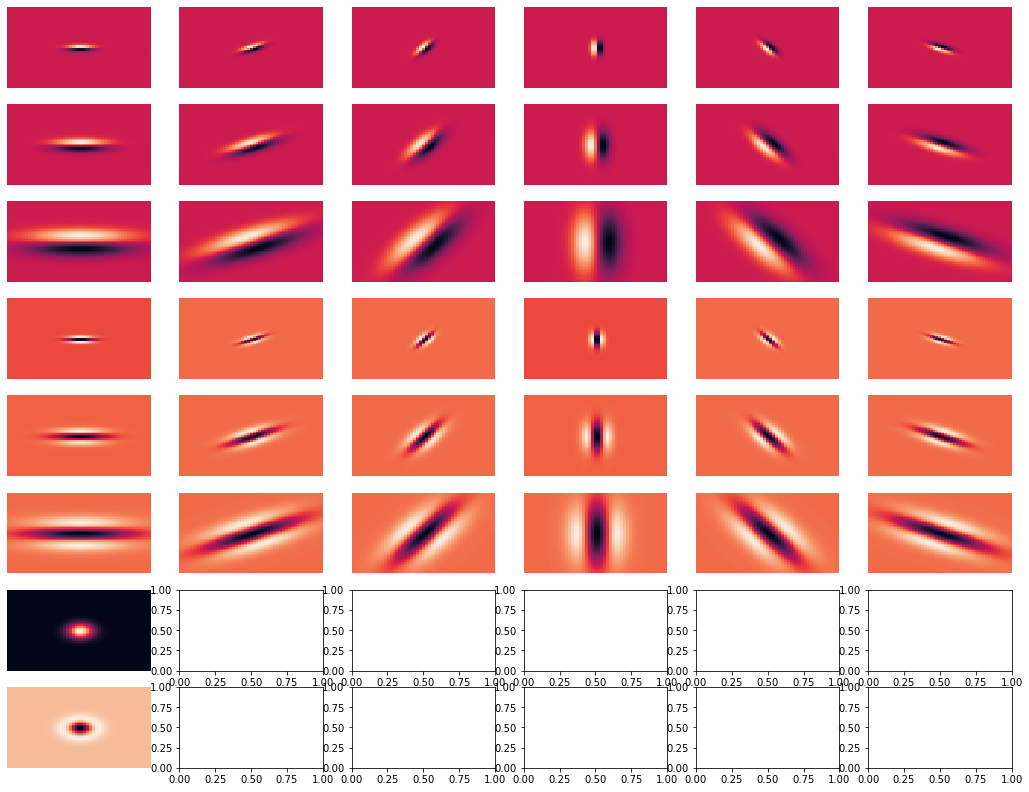

In [62]:
RFS = build_RFS()
fig, ax = plt.subplots(nrows = 8,ncols=6,figsize= (18,14))
row = 0
col = 0
for i in range(36):

	p = sns.heatmap(RFS[i],ax = ax[row][col], yticklabels=False,xticklabels=False, cbar=False)
 
	col += 1
	
	if col == 6:
		row += 1
		col = 0
    
p = sns.heatmap(RFS[36],ax = ax[6][0], yticklabels=False,xticklabels=False, cbar=False)
p = sns.heatmap(RFS[37],ax = ax[7][0], yticklabels=False,xticklabels=False, cbar=False)

plt.show()



In [63]:
#3
def mr8(image):
    RFS = build_RFS()
    img_final = np.zeros((image.shape[0], image.shape[1], 8))
    plane = 0
    for i in range(0, 36, 6):
        print(f'starting plane {plane}')
        for filter in RFS[i:i+6]:
            act = convolve2d(image, filter, mode='same')
            img_final[:, :, plane] = np.maximum(act, img_final[:, :, plane])

        plane += 1
    img_final[:, :, 6] = convolve2d(image, RFS[36], mode='same') # Gaussian 
    img_final[:, :, 7] = convolve2d(image, RFS[37], mode='same') #LoG

    return img_final


In [64]:
r_all_mr8 = mr8(image2[:, :, 0])
g_all_mr8 = mr8(image2[:, :, 1])
b_all_mr8 = mr8(image2[:, :, 2])

starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5


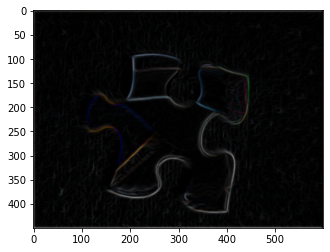

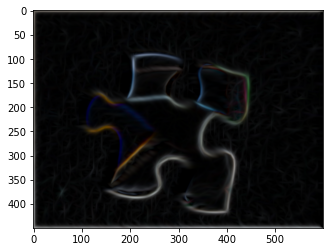

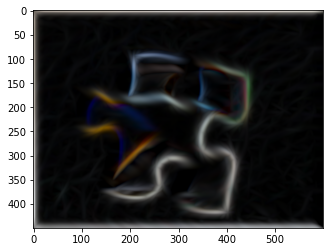

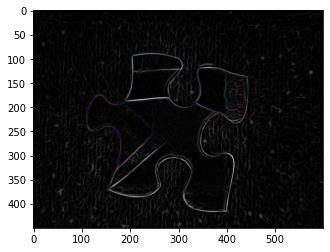

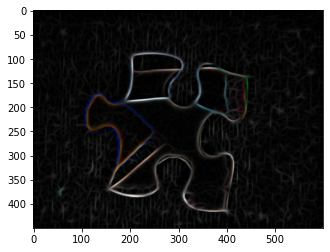

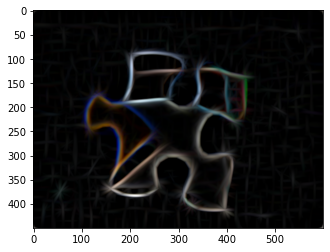

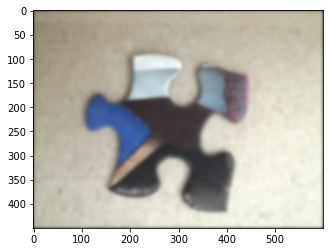

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


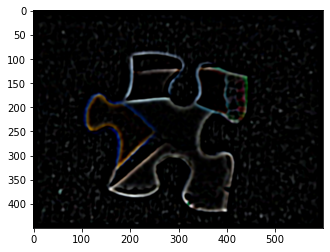

In [65]:
for i in range(8):
    plt.imshow(np.swapaxes(np.swapaxes(np.array([r_all_mr8[:, :, i]/np.max(r_all_mr8[:, :, i]), g_all_mr8[:, :, i]/np.max(g_all_mr8[:, :, i]), b_all_mr8[:, :, i]/np.max(b_all_mr8[:, :, i])]), 0, 1), 1, 2))
    plt.show()

## 3 Local Binary Patterns and Haar Filters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


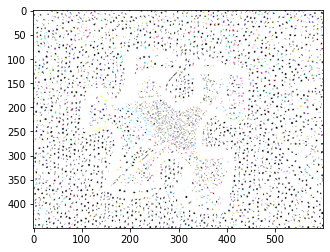

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


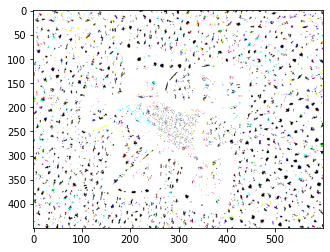

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


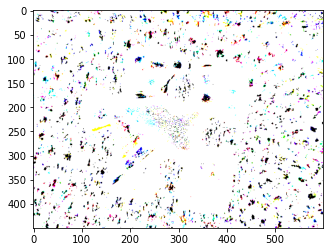

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


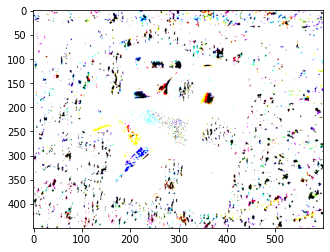

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


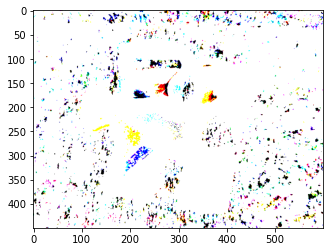

In [66]:
#1

for radius in [4,8,16,24,32]:
	img = np.zeros(image2.shape)
	for channel in [0,1,2]:
		
		img[:,:,channel] = skimage.feature.local_binary_pattern(image2[:,:,channel],12,radius)
	
	plt.imshow(img)
	plt.show()

In [67]:
#1

img_lbp = np.zeros((image2.shape[0], image2.shape[1], 3 * 5))

pos = 0
for radius in [4,8,16,24,32]:
	for channel in [0,1,2]:
		img_lbp[:, :, pos] = skimage.feature.local_binary_pattern(image2[:,:,channel],12,radius)
		pos += 1

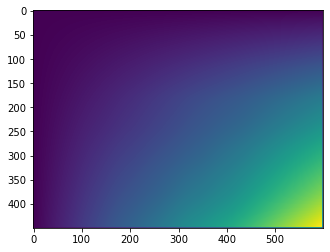

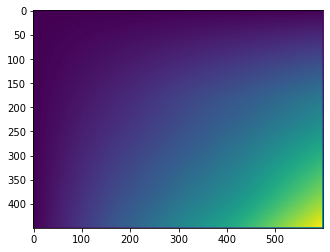

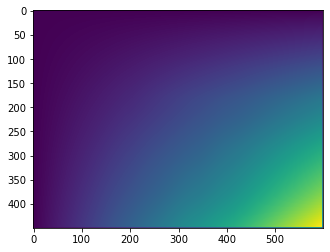

In [68]:
#2
def integral_images(image):
	i_image = np.zeros(image.shape)
	i_image = np.pad(i_image,1)

	for x in range(1,image.shape[0]):
		for y in range(1,image.shape[1]):
			i_image[x,y] = image[x,y] + i_image[x-1,y] + i_image[x,y-1] - i_image[x-1,y-1]

	return i_image[1:-1,1:-1]


img_r = integral_images(image2[:,:,0])
plt.imshow(img_r)
plt.show()

img_g = integral_images(image2[:,:,1])
plt.imshow(img_g)
plt.show()

img_b = integral_images(image2[:,:,2])
plt.imshow(img_b)
plt.show()

In [102]:
#3
def haar_filter(kernel_size):
	filter = np.full((kernel_size,kernel_size),-1)
	
	filter[0:kernel_size//2,0:kernel_size//2] = 1
	filter[kernel_size//2:,kernel_size//2:] = 1

	return filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


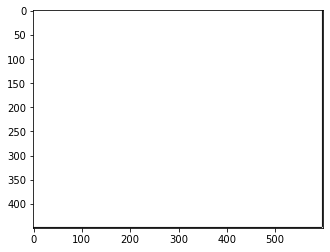

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


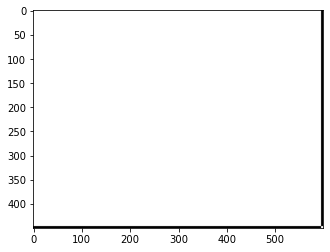

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


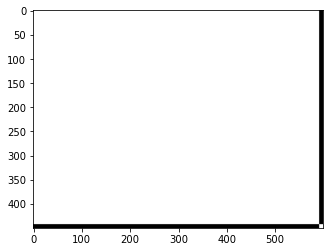

In [118]:
haar_img_4 = np.zeros(image2.shape)
filter_4 = haar_filter(4)

haar_img_8 = np.zeros(image2.shape)
filter_8 = haar_filter(8)

haar_img_16 = np.zeros(image2.shape)
filter_16 = haar_filter(16)

for c,i_image in enumerate([img_r,img_g,img_b]):
    
    haar_img_4[:,:,c] = convolve2d(i_image,filter_4,mode = 'same')
    haar_img_8[:,:,c] = convolve2d(i_image,filter_8,mode = 'same')
    haar_img_16[:,:,c] = convolve2d(i_image,filter_16,mode = 'same')

plt.imshow(haar_img_4)
plt.show()
plt.imshow(haar_img_8)
plt.show()
plt.imshow(haar_img_16)
plt.show()

# 4 Textons and Classification

In [71]:
def convolve(img, kernel):
    img_conv = np.zeros(img.shape)
    for i in range(3):
        img_conv[:, :, i] = convolve2d(img[:, :, i], kernel, mode='same') # applying the convolution to each channel seperately
    return img_conv

v_prewitt = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])
h_prewitt = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])
laplacian = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
])

#6.2
img_v_prewitt = convolve(image2, v_prewitt)
img_h_prewitt = convolve(image2, h_prewitt)
img_laplacian = convolve(image2, laplacian)

Feature matrix will consist of:

1. Gaussian Filter
2. LoG filter
3. DoG filter
4. Prewitt V
5. Prewitt H
6. Laplacian
7. 38x RFS Bank
8. 8x MR8 Bank
9. 5x LBP
10. 3x Haar
11. RBG
12. HSV

Total = 61 features for each pixel

Total * 3 for RGB 

In [73]:
def apply_rfs(image):
    rfs = build_RFS()

    ret = np.zeros((image.shape[0], image.shape[1], 3*len(rfs)))
    pos = 0
    for f in rfs:
        for c in range(3):
            ret[:, :, pos] = convolve2d(image[:, :, c], f, mode='same')
            pos += 1

    return ret

In [83]:
#1
def build_feature(image):
    l = 3 + 3 + 3 + 3 + 3 + 3 + 114 + 8*3 + 15 + 9 + 3 + 3
    a = np.prod(image.shape[:-1])
    feature = np.zeros((a, l))

    # Gaussian filters
    feature[:, :3] = img_gauss.reshape(a, 3)
    feature[:, 3:6] = img_log.reshape(a, 3)
    feature[:, 6:9] = img_dog.reshape(a, 3)

    # Edge filters
    feature[:, 9:12] = img_v_prewitt.reshape(a, 3)
    feature[:, 12:15] = img_h_prewitt.reshape(a, 3)
    feature[:, 15:18] = img_laplacian.reshape(a, 3)

    # RFS
    feature[:, 18:132] = apply_rfs(image).reshape(a, 114)

    # MR8
    feature[:, 132:140] = mr8(image[:, :, 0]).reshape(a, 8)
    feature[:, 140:148] = mr8(image[:, :, 1]).reshape(a, 8)
    feature[:, 148:156] = mr8(image[:, :, 2]).reshape(a, 8)

    # LBP
    feature[:, 156:171] = img_lbp.reshape(a, 15)

    # Haar
    feature[:, 171:174] = haar_img_4.reshape(a, 3)
    feature[:, 174:177] = haar_img_8.reshape(a, 3)
    feature[:, 177:180] = haar_img_16.reshape(a, 3)

    # RGB
    feature[:, 180:183] = image.reshape(a, 3)

    # HSV
    feature[:, 183:186] = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_RGB2HSV).reshape(a, 3)

    return feature
    

feat = build_feature(image2)

starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5


In [85]:
#2
km = KMeans(n_clusters=4).fit(feat)

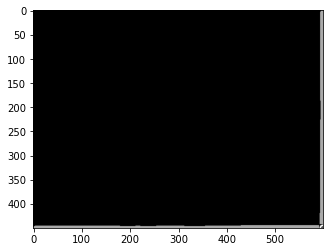

In [86]:
plt.imshow(km.labels_.reshape((450, 600)), cmap='gray')

In [87]:
feat = np.hstack((feat, km.labels_.reshape((270000,1))))
feat.shape

(270000, 187)

In [88]:
m = feat.mean(axis=0)
c = np.cov(feat.T)

In [89]:
#3
mvn = multivariate_normal(mean = m, cov = c, allow_singular=True)

64.08962962962963% accuracy


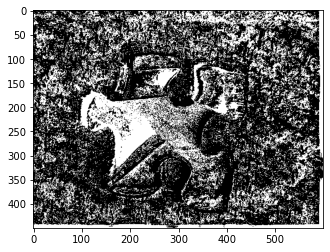

In [90]:
def get_mask(pdf, thresh):
    t = pdf < thresh
    t = t.astype(int)
    return t

def get_acc(our_mask, true_mask):
    a = 0
    for o, t in zip(our_mask.flatten(), true_mask.flatten()):
        a += np.abs(o - t)

    a /= our_mask.shape[0] * our_mask.shape[1]
    return 1-a

mask2 = cv2.imread('../images/mask-83.png', cv2.IMREAD_GRAYSCALE)

thresh = threshold_mean(mask2)

mask2_bin = (mask2 > thresh).astype(int)

pdf = mvn.pdf(feat).reshape(450, 600)

theta = np.max(pdf)*1/11000

a = get_acc(get_mask(pdf, theta), mask2_bin)

print(f'{a * 100}% accuracy')
plt.imshow(get_mask(pdf, theta), cmap='gray')
plt.show()

In [91]:
#4
image2_hsv = cv2.cvtColor(image2.astype(np.float32), cv2.COLOR_RGB2HSV)

feat = np.hstack((feat, mr8(image2_hsv[:, :, 0]).reshape((270000, 8))))
feat = np.hstack((feat, mr8(image2_hsv[:, :, 1]).reshape((270000, 8))))
feat = np.hstack((feat, mr8(image2_hsv[:, :, 2]).reshape((270000, 8))))


starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5
starting plane 0
starting plane 1
starting plane 2
starting plane 3
starting plane 4
starting plane 5


62.18666666666667% accuracy


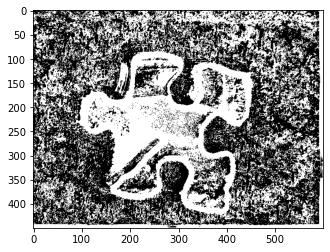

In [92]:
m = feat.mean(axis=0)
c = np.cov(feat.T)

mvn = multivariate_normal(mean = m, cov = c, allow_singular=True)

pdf = mvn.pdf(feat).reshape(450, 600)

theta = np.max(pdf)*1/1000

a = get_acc(get_mask(pdf, theta), mask2_bin)

print(f'{a * 100}% accuracy')
plt.imshow(get_mask(pdf, theta), cmap='gray')
plt.show()